# Importation des bibliotheques

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D ,BatchNormalization
from keras.optimizers import Adam , RMSprop , SGD
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from google.colab import drive 
import pandas as pd
%matplotlib inline
tf.__version__

'2.4.0'

Connexion au Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#le chemin du dossier 'data' qui contient deux dossiers , 'train' et 'test'
data_path='/content/drive/MyDrive/datasetskin/data'

In [ ]:
train_dir = os.path.join(data_path, "train")
test_dir = os.path.join(data_path, "test")

In [ ]:
# utile pour obtenir le nombre de classes
folders = glob(train_dir+'/*')

# Augmentation

ImageDataGenerator() est une technique d’application de différentes transformations aux images originales qui se traduit par de multiples copies transformées de la même image. Chaque copie, cependant, est différente de l’autre dans certains aspects en fonction des techniques d’augmentation que vous appliquez comme le déplacement, la rotation, le retournement, etc.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
#on a fixé le batch_size à 64 pour les images d'entrenement et du test.
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
#Tailles des images
IMG_SHAPE = (224, 224,3)

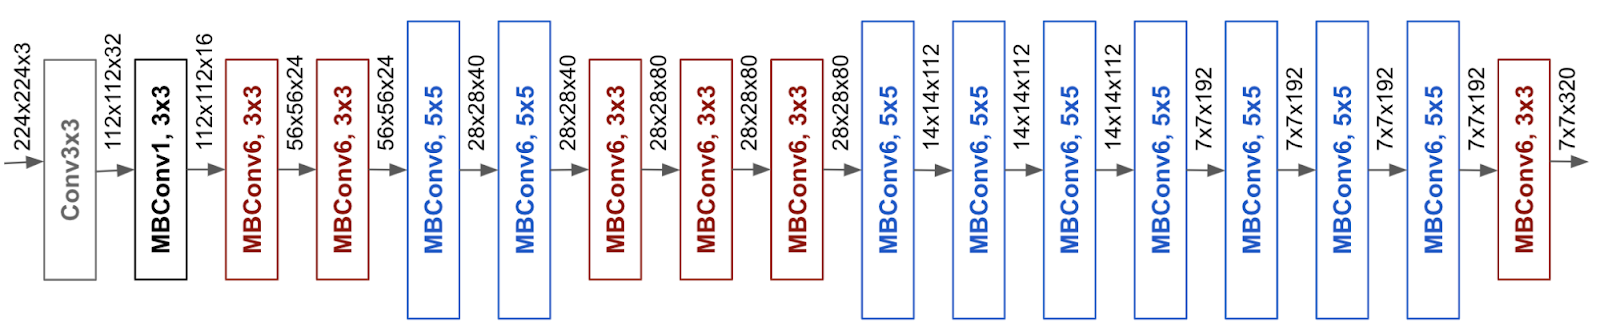

EfficientNet est une nouvelle méthode de mise à l’échelle de modèle, développée par Google récemment , pour augmenter les CNN. Il utilise un coefficient composé simple et très efficace. EfficientNet fonctionne différemment des méthodes traditionnelles qui mesurent les dimensions des réseaux, telles que la largeur, la profondeur et la résolution; et il ajuste chaque dimension avec un ensemble fixe de coefficients d’échelle uniformément. Sur le plan pratique, la mise à l’échelle des dimensions individuelles améliore le rendement du modèle; cependant, l’équilibre de toutes les dimensions du réseau par rapport aux ressources disponibles améliore efficacement l’ensemble du rendement

In [ ]:
!pip install efficientnet
import efficientnet.tfkeras as efn 

In [ ]:
Efficient = efn.EfficientNetB0(
        weights='imagenet',
        input_shape= IMG_SHAPE,
        include_top=False)

# Freezing

In [ ]:
Efficient.trainable = False

In [ ]:
# our layers - you can add more if you want
x3 = Efficient.output
x3 = GlobalAveragePooling2D()(x3)
x3 = Dense(128, activation='relu')(x3)
x3 = Dropout(0.5)(x3)
x3 = BatchNormalization()(x3)
prediction3 = Dense(len(folders), activation='softmax')(x3)

In [ ]:
model_EfficientNetB0 = Model(inputs=Efficient.input, outputs=prediction3)

In [ ]:
model_EfficientNetB0.compile(  loss='binary_crossentropy',
  optimizer= RMSprop(lr=0.0001, decay=1e-6),
  metrics=['accuracy'])

In [ ]:
#Réduire le taux d’apprentissage lorsqu’une mesure cesse de s’améliorer.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Entrainement

In [ ]:
history_B0=model_EfficientNetB0.fit(training_set, epochs=50, validation_data=test_set,callbacks=[learning_rate_reduction])

Epoch 1/50
83/83 [==============================] - 43s 431ms/step - loss: 0.7383 - accuracy: 0.6359 - val_loss: 0.5292 - val_accuracy: 0.8121
Epoch 2/50
83/83 [==============================] - 34s 415ms/step - loss: 0.5679 - accuracy: 0.7730 - val_loss: 0.4569 - val_accuracy: 0.8303
Epoch 3/50
83/83 [==============================] - 34s 414ms/step - loss: 0.5021 - accuracy: 0.7895 - val_loss: 0.4170 - val_accuracy: 0.8303
Epoch 4/50
83/83 [==============================] - 34s 415ms/step - loss: 0.4940 - accuracy: 0.7855 - val_loss: 0.3906 - val_accuracy: 0.8455
Epoch 5/50
83/83 [==============================] - 35s 421ms/step - loss: 0.4527 - accuracy: 0.8072 - val_loss: 0.3860 - val_accuracy: 0.8485
Epoch 6/50
83/83 [==============================] - 34s 415ms/step - loss: 0.4345 - accuracy: 0.8181 - val_loss: 0.3703 - val_accuracy: 0.8515
Epoch 7/50
83/83 [==============================] - 34s 414ms/step - loss: 0.4011 - accuracy: 0.8370 - val_loss: 0.3589 - val_accuracy: 0.8576

# Plot

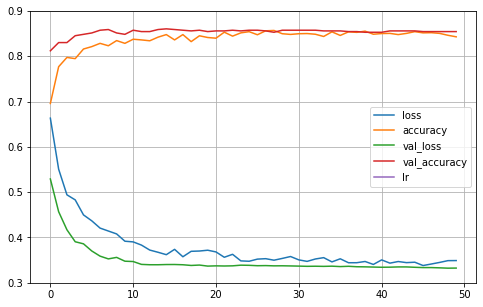

In [ ]:
pd.DataFrame(history_B0.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.3, 0.9)
plt.show()

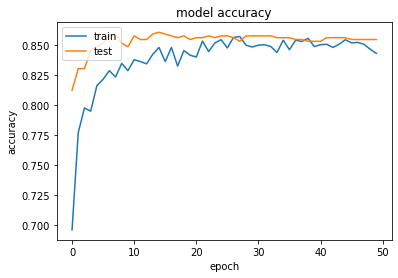

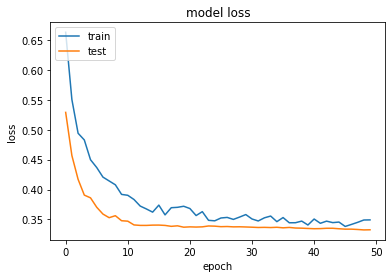

In [ ]:
# summarize history for accuracy
plt.plot(history_B0.history['accuracy'])
plt.plot(history_B0.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_B0.history['loss'])
plt.plot(history_B0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Fine-tuning

In [ ]:
Efficient.trainable = True

In [ ]:
model_EfficientNetB0.compile(  loss='binary_crossentropy',
  optimizer=SGD(lr=0.00001,momentum=0.9),
  metrics=['accuracy'])

In [ ]:
fine_tuning_B0 = model_EfficientNetB0.fit(training_set, epochs=100, validation_data=test_set)

Epoch 1/100
83/83 [==============================] - 50s 525ms/step - loss: 0.9718 - accuracy: 0.5161 - val_loss: 0.7032 - val_accuracy: 0.6394
Epoch 2/100
83/83 [==============================] - 42s 508ms/step - loss: 0.9634 - accuracy: 0.4992 - val_loss: 0.8119 - val_accuracy: 0.6015
Epoch 3/100
83/83 [==============================] - 42s 508ms/step - loss: 0.8835 - accuracy: 0.5740 - val_loss: 0.7077 - val_accuracy: 0.6333
Epoch 4/100
83/83 [==============================] - 42s 507ms/step - loss: 0.8804 - accuracy: 0.5485 - val_loss: 0.6646 - val_accuracy: 0.6667
Epoch 5/100
83/83 [==============================] - 42s 507ms/step - loss: 0.8106 - accuracy: 0.6160 - val_loss: 0.6789 - val_accuracy: 0.6576
Epoch 6/100
83/83 [==============================] - 42s 508ms/step - loss: 0.8051 - accuracy: 0.6022 - val_loss: 0.6984 - val_accuracy: 0.6212
Epoch 7/100
83/83 [==============================] - 42s 508ms/step - loss: 0.8498 - accuracy: 0.5866 - val_loss: 0.6992 - val_accuracy:

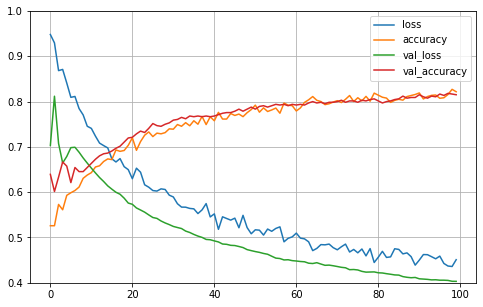

In [ ]:
pd.DataFrame(fine_tuning_B0.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.4, 1)
plt.show()

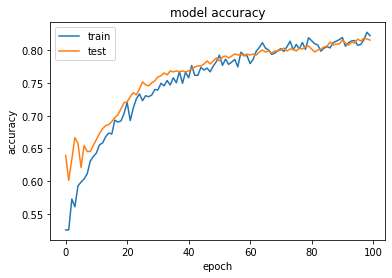

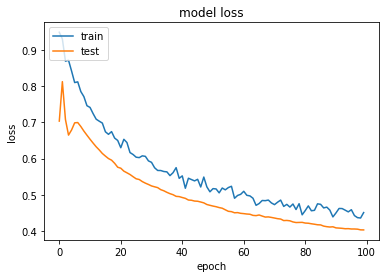

In [ ]:
# summarize history for accuracy
plt.plot(fine_tuning_B0.history['accuracy'])
plt.plot(fine_tuning_B0.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fine_tuning_B0.history['loss'])
plt.plot(fine_tuning_B0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()